# Practice Questions Solutions

# Retrieval For Images

![Alt](diagrams/RAG%20-%20Retrieval%20For%20Images.jpg)

### Practice
1) Use FAISS library + CLIP's embedding model for vision
2) Use cat/dog images in "images" directory(paths already defined below)
3) Create an image store and VectorDB, store them in images directory
4) Use the query image(path defined below)
5) Perform similarity search and retrieve top 2 images

In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel
import faiss
from PIL import Image
import matplotlib.pyplot as plt
import json

In [3]:
img_paths = {
    0: "images/german_sheperd.jpg",
    1: "images/Golden_Retriever.jpg",
    2: "images/siberian_husky.jpg",
    3: "images/persian_cat.jpg",
    4: "images/scottish_fold_cat.jpg",
    5: "images/sphynx_cat.jpg"
}
query_img = "images/query_german_sheperd.jpg"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.eval()

img_store_save_path = "images/image_store.json"
vectorDB_save_path = "images/image_VectorDB.faiss"

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


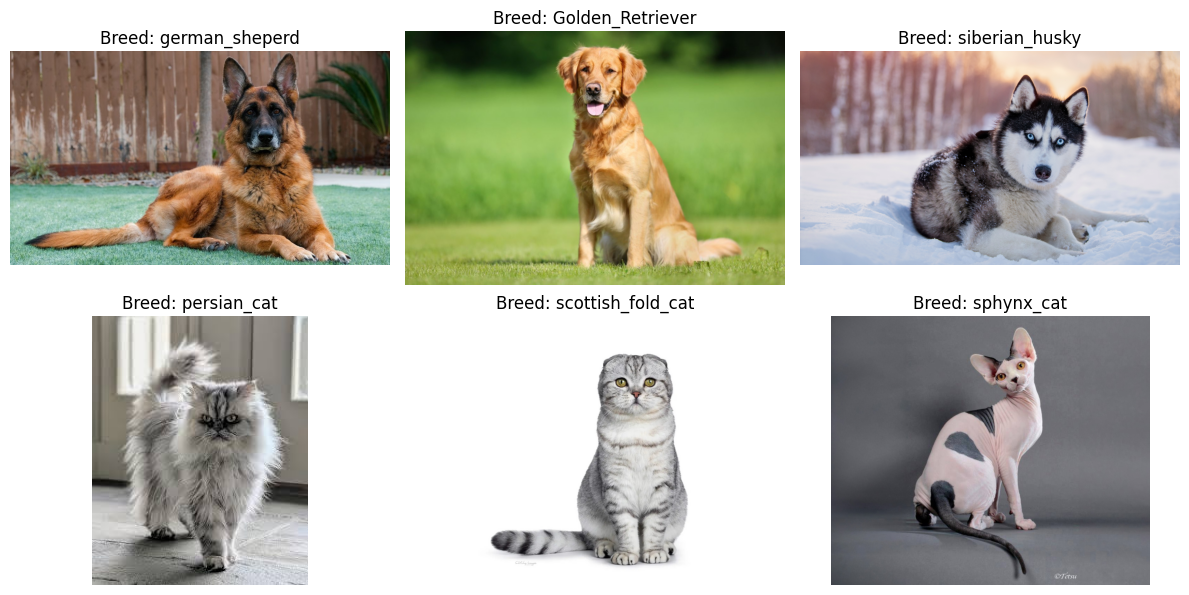

In [4]:
plt.figure(figsize=(12, 6))

for idx, (label, path) in enumerate(img_paths.items()):
    img = Image.open(path)
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(f"Breed: {path.split("/")[1][:-4]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Breed: German Sheperd')

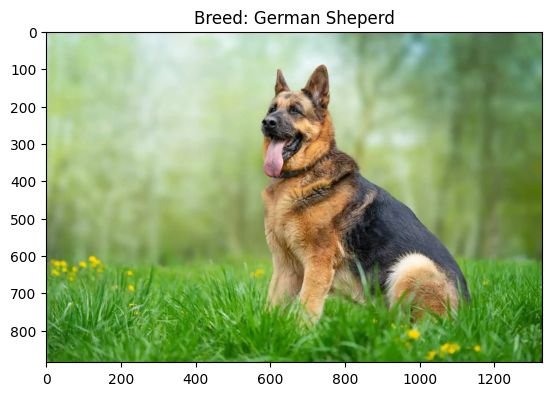

In [5]:
img = Image.open(query_img)
plt.imshow(img)
plt.title(f"Breed: German Sheperd")

In [17]:
# model.get_output_embeddings

In [6]:
index = faiss.IndexFlatL2(512) # create faiss index of 768 dimension and use L2 distance as distance metric

In [7]:
for idx, (label, path) in enumerate(img_paths.items()):
    img = Image.open(path)
    
    # Preprocess
    inputs = processor(images=img, return_tensors="pt")
    image_tensor = inputs['pixel_values']  # shape: (1, 3, 224, 224)
    
    # Encode
    with torch.no_grad():
        embeddings = model.get_image_features(image_tensor)  # Hugging Face
        embeddings = embeddings.cpu().numpy().astype('float32')  # convert to NumPy
        
    faiss.normalize_L2(embeddings) # L2 normalize
    index.add(embeddings) # Add to FAISS index

In [9]:
faiss.write_index(index, vectorDB_save_path) # Save vectorDB

# Save Image store
with open(img_store_save_path, "w") as f:
    json.dump(img_paths, f, indent=4)

In [12]:
img = Image.open(query_img)

# Preprocess
inputs = processor(images=img, return_tensors="pt")
image_tensor = inputs['pixel_values']  # shape: (1, 3, 224, 224)

# Encode
with torch.no_grad():
    embeddings = model.get_image_features(image_tensor)  # Hugging Face
    embeddings = embeddings.cpu().numpy().astype('float32')  # convert to NumPy
    
print(embeddings.shape)
faiss.normalize_L2(embeddings)
distances, indices = index.search(embeddings, k=3)

(1, 512)


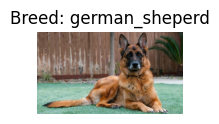

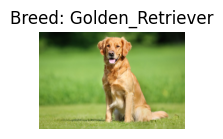

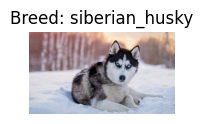

In [11]:
for idx in indices[0]:
    img_pth = img_paths[idx]
    img = Image.open(img_pth)
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(f"Breed: {img_pth.split("/")[1][:-4]}")
    plt.axis("off")
    plt.show()

## Cross-model/Mulitmodal Retrieval

![Alt text](diagrams/RAG%20-%20Cross-Model%20RetrievalMultimodal%20Retrieval.jpg)

## Text-to-Image Retrieval

![Alt text](diagrams/RAG%20-%20Text-to-Image%20Retrieval.jpg)

### Practice
1) Use FAISS library & CLIP's vision encoder + text decoder
2) Load the existing image store + VectorDB created previously
3) Use the sample query text given below
3) Perform similarity search and retrieve top 2 images

In [32]:
import faiss
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

In [4]:
img_store = "images/image_store.json"
faiss_index_pth = "images/image_VectorDB.faiss"

In [ ]:
with open(img_store, "r") as f:
    img_paths = {int(k): v for k, v in json.load(f).items()}

index = faiss.read_index(faiss_index_pth)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [26]:
text = "A sphynx cat"

# Preprocess
inputs = processor(text=text, return_tensors="pt", padding=True)

# Encode
with torch.no_grad():
    embeddings = model.get_text_features(**inputs)
    embeddings = embeddings.cpu().numpy().astype('float32')  # convert to NumPy
    
print(embeddings.shape)
faiss.normalize_L2(embeddings)
distances, indices = index.search(embeddings, k=3)

(1, 512)


In [27]:
indices

array([[5, 4, 3]])

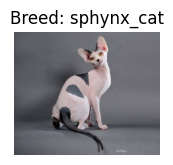

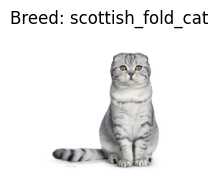

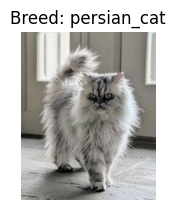

In [34]:
for idx in indices[0]:
    img_pth = img_paths[int(idx)]
    img = Image.open(img_pth)
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(f"Breed: {img_pth.split("/")[1][:-4]}")
    plt.axis("off")
    plt.show()

## Image-to-Text Retreival

![Alt text](diagrams/RAG%20-%20Image-to-text%20Retrieval.jpg)

### Practice
1) Use FAISS library & CLIP's vision encoder + text decoder.
2) load sentences from sentences.txt, make document store + VectorDB out of it.
3) Also store document store + VectorDB in texts folder.
4) Use the query image(path defined below)
5) Perform similarity search and retrieve top 2 sentences.

In [1]:
import faiss
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer

In [9]:
text_embedding_model = SentenceTransformer("paraphrase-mpnet-base-v2") # bert-base-nli-mean-tokens

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text_embedding_model.eval()
model.eval()
print("")

In [30]:
txt_src_file = "texts/sentences.txt"
query_img = "images/query_german_sheperd.jpg"

vectorDB_save_path = "texts/text_VectorDB.faiss"
document_store_path = "texts/document_store.json"

In [23]:
with open(txt_src_file, "r") as f:
    sentences = f.readlines()

sentences = [line.strip() for line in sentences]
document_store = {i: sent for i, sent in enumerate(sentences)}
document_store

{0: 'A German Sheperd',
 1: 'A Golden Retriever',
 2: 'A Siberian Husky',
 3: 'A Sphynx Cat',
 4: 'A Scottish Fold Cat',
 5: 'A Persian Cat'}

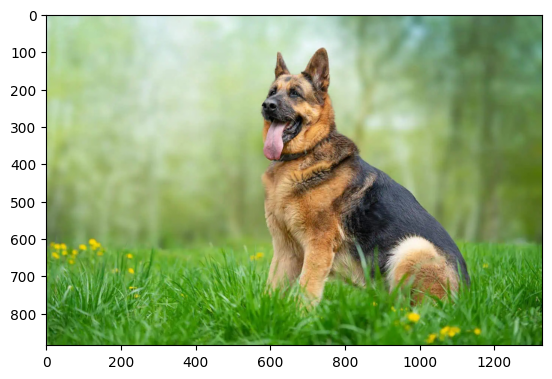

In [31]:
img = Image.open(query_img)
plt.imshow(img)

In [33]:
index = faiss.IndexFlatL2(512) # create faiss index of 768 dimension and use L2 distance as distance metric

for sent in sentences:

    inputs = processor(text=sent, return_tensors="pt", padding=True)

    # Encode
    with torch.no_grad():
        embeddings = model.get_text_features(**inputs)
        embeddings = embeddings.cpu().numpy().astype('float32')  # convert to NumPy

    faiss.normalize_L2(embeddings) # so only angle matters, not the magnitude

    index.add(embeddings) # embeddings added into index/VectorDB

In [34]:
faiss.write_index(index, vectorDB_save_path) # Save vectorDB

# Save Image store
with open(document_store_path, "w") as f:
    json.dump(document_store, f, indent=4)

In [35]:
img = Image.open(query_img)

# Preprocess
inputs = processor(images=img, return_tensors="pt")
image_tensor = inputs['pixel_values']  # shape: (1, 3, 224, 224)

# Encode
with torch.no_grad():
    embeddings = model.get_image_features(image_tensor)  # Hugging Face
    embeddings = embeddings.cpu().numpy().astype('float32')  # convert to NumPy
    
print(embeddings.shape)
faiss.normalize_L2(embeddings)
distances, indices = index.search(embeddings, k=3)

(1, 512)


In [36]:
indices[0]

array([0, 1, 2])

In [39]:
for idx in indices[0]:
    print(document_store[idx])

A German Sheperd
A Golden Retriever
A Siberian Husky
